!pip install pytorch-lightning==1.3.0rc2

!pip install ruptures

!pip install git+https://github.com/PyTorchLightning/pytorch-lightning


!pip install torch==1.8.1

In [1]:
from CPD import loss, metrics, models, new_metrics, datasets
from CPD.masks import *
from CPD.utils import *
import tensorflow as tf

import torch
import torch.nn as nn
# save numpy array as csv file
import numpy as np
from numpy import asarray
from numpy import savetxt

import datetime
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

%load_ext autoreload
%autoreload

/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/pims/image_reader.py:26: RuntimeWarning: PIMS image_reader.py could not find scikit-image. Falling back to matplotlib's imread(), which uses floats instead of integers. This may break your scripts. 
(To ignore this warning, include the line "warnings.simplefilter("ignore", RuntimeWarning)" in your script.)
  warnings.warn(RuntimeWarning(ski_preferred))


In [2]:
import torch
torch.__version__

'1.9.1'

In [3]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import scipy.sparse

In [4]:
pl.__version__

'1.5.6'

In [5]:
random_seed = 1 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)


In [6]:
def my_train(N, D, exp, exp_type, max_epochs=60, dataset_name='mnist64', SEQ_LEN=64, replace=False):
    IM_SIZE = 28
    input_size = IM_SIZE * IM_SIZE
    hidden_rnn = 10 #100
    rnn_n_layers = 2
    linear_dims = [100, 50]
    rnn_dropout = 0.5
    dim_feedforward = 50
    models_metrics = []
    nhead = 4
    without_mask = False
    # replace == True: we wwant to get all hyperparametrs in mask uniformly
    if exp[-4:] == 'diag' and replace == True:
        D = np.linspace(1, int(SEQ_LEN/2), int(np.log2(512)), dtype=int)
    # N - amount of experiment's repeating
    for n in N:
        for d in D:
            if exp in ['triang', '3masks', 'transformer', 'rnn'] :
                exp_name = exp
            else:
                exp_name = str(d)+'-'+str(exp)
            model_metric = []
            if exp == 'transformer':
                base_model = models.MnistTransformer(
                                                 input_size=input_size, name_mask='without',
                                                 linear_dims=linear_dims, nhead=nhead,
                                                 dim_feedforward=dim_feedforward, dropout=0.5, flag_mask=False)
                without_mask = True
            if exp == 'rnn':
                base_model = models.MnistRNN(input_size, hidden_rnn, rnn_n_layers, linear_dims, rnn_dropout=0.0, 
                                             dropout=0.5,  rnn_type='LSTM')
                without_mask = True
            if exp == '3masks':
                base_model = models.MnistTransformer_3masks(
                                                      input_size=input_size, linear_dims=linear_dims, seq_len=SEQ_LEN,
                                                      nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.5)
            if exp not in ['3masks', 'rnn', 'transformer']:
                mask = get_mask(d=d, exp=exp, SEQ_LEN=SEQ_LEN)#.to('cuda')                                           
                base_model = models.MnistTransformer(
                                                input_size=input_size, linear_dims=linear_dims,
                                                src_mask=~mask, name_mask=exp_name,
                                                nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.5)
            train_model = models.CPD_model(
                                            model=base_model, T=SEQ_LEN, # // 4, #было // 4, что это значит??
                                            loss_type='CPD',
                                            experiment_type=dataset_name,  
                                            lr=0.001, 
                                            batch_size=64)

            current_time = datetime.datetime.now().strftime("%m%d%Y_%H-%M-%S")
            if dataset_name[-7:] == 'changes':
                path_ = 'n_changes_experiment/'+dataset_name
            elif dataset_name[:4] == 'mnist':
                path_ = 'seqlen_experiment/'+dataset_name

            logger = pl.loggers.TensorBoardLogger(save_dir=path_+'/logs/',
                                                  name=exp_name, log_graph=True)
            early_stop_callback = EarlyStopping(monitor="val_loss", 
                                                min_delta=0.00,
                                                patience=10, 
                                                verbose=True, 
                                                mode="min")

            checkpoint_callback = ModelCheckpoint( dirpath=path_+'/saves/'+exp_name,
                        filename=str(SEQ_LEN)+'_'+exp_name+'_v'+str(n)+'_'+exp_type+'_{epoch}-{val_loss:.2f}-{val_acc:.2f}', 
                        every_n_epochs=1)
            # отображать валидационные логи
            #from pl_bolts.callbacks import PrintTableMetricsCallback
            #callback = PrintTableMetricsCallback()
            trainer = pl.Trainer(
                                max_epochs=max_epochs, 
                                log_every_n_steps=5,
                                gpus=1, 
                                benchmark=True, 
                                check_val_every_n_epoch=1,
                                gradient_clip_val=0.5,
                                logger = logger,
                                callbacks = [
                                    #callback,
                                    early_stop_callback,
                                    checkpoint_callback])
            print("Dataset ", dataset_name)
            print("MAX epochs ", max_epochs)
            print("Train model ", exp_name)
            trainer.fit(train_model)
            get_model_metrics(train_model=train_model, 
                                      base_model=base_model, n=n,
                                      exp_type=exp_type,
                                      exp_name=exp_name, 
                                      SEQ_LEN=SEQ_LEN,
                                      threshold_number = 10,
                                      dataset_name=dataset_name,
                                      without_mask=without_mask,
                                      savefigure=True, #False means don't save images
                                      savetext=True
                                     )


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:251: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  UserWarning,

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | MnistTransformer_3masks | 2.5 M 
1 | loss  | CPDLoss                 | 0     
--------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.180    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -18.529


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: -18.529. Signaling Trainer to stop.


Device in prediction's plots:  cpu
All masks are on  cpu
Not module transformer with mask
transformer with 3 mask,  4changes, CPD
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 0, TN: 604, FN: 596, DELAY:23.2325, FP_DELAY:64.0
TP: 0, FP: 0, TN: 604, FN: 596, DELAY:23.2325, FP_DELAY:64.0
TP: 0, FP: 0, TN: 604, FN: 596, DELAY:23.2325, FP_DELAY:64.0
TP: 0, FP: 0, TN: 604, FN: 596, DELAY:23.2325, FP_DELAY:64.0
TP: 0, FP: 0, TN: 604, FN: 596, DELAY:23.2325, FP_DELAY:64.0
TP: 0, FP: 0, TN: 604, FN: 596, DELAY:23.2325, FP_DELAY:64.0
TP: 0, FP: 0, TN: 604, FN: 596, DELAY:23.2325, FP_DELAY:64.0
TP: 0, FP: 0, TN: 604, FN: 596, DELAY:23.2325, FP_DELAY:64.0
TP: 0, FP: 0, TN: 604, FN: 596, DELAY:23.2325, FP_DELAY:64.0
TP: 0, FP: 0, TN: 604, FN: 596, DELAY:23.2325, FP_DELAY:64.0
TP: 0, FP: 0, TN: 604, FN: 596, DELAY:23.2325, FP_DELAY:64.0


/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:251: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  UserWarning,

  | Name  | Type     | Params
-----------------------------------
0 | model | MnistRNN | 38.9 K
1 | loss  | CPDLoss  | 0     
-----------------------------------
38.9 K    Trainable params
0         Non-trainable params


Save metrics in  n_changes_experiment/all_metrics.txt


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -1.103


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 10.961 >= min_delta = 0.0. New best score: -12.064


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 8.693 >= min_delta = 0.0. New best score: -20.757


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 6.821 >= min_delta = 0.0. New best score: -27.578


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 3.233 >= min_delta = 0.0. New best score: -30.811


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 2.061 >= min_delta = 0.0. New best score: -32.872


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 2.281 >= min_delta = 0.0. New best score: -35.153


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.299 >= min_delta = 0.0. New best score: -35.452


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.754 >= min_delta = 0.0. New best score: -36.206


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.024 >= min_delta = 0.0. New best score: -37.230


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.488 >= min_delta = 0.0. New best score: -37.718


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.200 >= min_delta = 0.0. New best score: -37.917


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.268 >= min_delta = 0.0. New best score: -38.185


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: -38.218


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: -38.277


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.382 >= min_delta = 0.0. New best score: -38.659


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: -38.728


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.186 >= min_delta = 0.0. New best score: -38.914


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: -38.918


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: -38.947


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: -38.985


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: -39.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: -39.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: -39.026


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: -39.058


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: -39.075


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: -39.081


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.105 >= min_delta = 0.0. New best score: -39.187


Validating: 0it [00:00, ?it/s]

Device in prediction's plots:  cpu
Not module transformer_3masks
Not module transformer with mask
rnn 4changes, CPD
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 506, FP: 113, TN: 573, FN: 8, DELAY:0.3566666666666667, FP_DELAY:39.9275
TP: 513, FP: 102, TN: 576, FN: 9, DELAY:0.38916666666666666, FP_DELAY:40.104166666666664
TP: 517, FP: 94, TN: 580, FN: 9, DELAY:0.395, FP_DELAY:40.2475
TP: 519, FP: 92, TN: 580, FN: 9, DELAY:0.3958333333333333, FP_DELAY:40.25416666666667
TP: 522, FP: 87, TN: 581, FN: 10, DELAY:0.4266666666666667, FP_DELAY:40.29333333333334
TP: 523, FP: 83, TN: 582, FN: 12, DELAY:0.5508333333333333, FP_DELAY:40.4625
TP: 525, FP: 80, TN: 582, FN: 13, DELAY:0.5925, FP_DELAY:40.509166666666665
TP: 529, FP: 71, TN: 583, FN: 17, DELAY:0.7316666666666667, FP_DELAY:40.695
TP: 544, FP: 49, TN: 584, FN: 23, DELAY:0.9875, FP_DELAY:40.9775
TP: 534, FP: 39, TN: 584, FN: 43, DELAY:1.855, FP_DELAY:41.840833333333336
TP: 0, FP: 0, TN: 588, FN: 612, DELAY:23.8125, FP_DELAY:64

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:251: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  UserWarning,

  | Name  | Type             | Params
-------------------------------------------
0 | model | MnistTransformer | 2.5 M 
1 | loss  | CPDLoss          | 0     
-------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.180    Total estimated model params size (MB)


Save metrics in  n_changes_experiment/all_metrics.txt


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -18.610


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: -18.610. Signaling Trainer to stop.


Device in prediction's plots:  cpu
Not module transformer_3masks
Not module transformer with mask
transformerwithout mask,  4changes, CPD
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 0, TN: 599, FN: 601, DELAY:23.18166666666667, FP_DELAY:64.0
TP: 0, FP: 0, TN: 599, FN: 601, DELAY:23.18166666666667, FP_DELAY:64.0
TP: 0, FP: 0, TN: 599, FN: 601, DELAY:23.18166666666667, FP_DELAY:64.0
TP: 0, FP: 0, TN: 599, FN: 601, DELAY:23.18166666666667, FP_DELAY:64.0
TP: 0, FP: 0, TN: 599, FN: 601, DELAY:23.18166666666667, FP_DELAY:64.0
TP: 0, FP: 0, TN: 599, FN: 601, DELAY:23.18166666666667, FP_DELAY:64.0
TP: 0, FP: 0, TN: 599, FN: 601, DELAY:23.18166666666667, FP_DELAY:64.0
TP: 0, FP: 0, TN: 599, FN: 601, DELAY:23.18166666666667, FP_DELAY:64.0
TP: 0, FP: 0, TN: 599, FN: 601, DELAY:23.18166666666667, FP_DELAY:64.0
TP: 0, FP: 0, TN: 599, FN: 601, DELAY:23.18166666666667, FP_DELAY:64.0
TP: 0, FP: 0, TN: 599, FN: 601, DELAY:23.18166666666667, FP_DELAY:64.0


/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:251: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  UserWarning,

  | Name  | Type             | Params
-------------------------------------------
0 | model | MnistTransformer | 2.5 M 
1 | loss  | CPDLoss          | 0     
-------------------------------------------
2.5 M     Trainabl

Save metrics in  n_changes_experiment/all_metrics.txt


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -19.910


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: -19.910. Signaling Trainer to stop.


Device in prediction's plots:  cpu
Not module transformer_3masks
Src mask is on  cpu
transformer with 10-triang-1diag mask,  4changes, CPD
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 0, TN: 617, FN: 583, DELAY:22.5425, FP_DELAY:64.0
TP: 0, FP: 0, TN: 617, FN: 583, DELAY:22.5425, FP_DELAY:64.0
TP: 0, FP: 0, TN: 617, FN: 583, DELAY:22.5425, FP_DELAY:64.0
TP: 0, FP: 0, TN: 617, FN: 583, DELAY:22.5425, FP_DELAY:64.0
TP: 0, FP: 0, TN: 617, FN: 583, DELAY:22.5425, FP_DELAY:64.0
TP: 0, FP: 0, TN: 617, FN: 583, DELAY:22.5425, FP_DELAY:64.0
TP: 0, FP: 0, TN: 617, FN: 583, DELAY:22.5425, FP_DELAY:64.0
TP: 0, FP: 0, TN: 617, FN: 583, DELAY:22.5425, FP_DELAY:64.0
TP: 0, FP: 0, TN: 617, FN: 583, DELAY:22.5425, FP_DELAY:64.0
TP: 0, FP: 0, TN: 617, FN: 583, DELAY:22.5425, FP_DELAY:64.0
TP: 0, FP: 0, TN: 617, FN: 583, DELAY:22.5425, FP_DELAY:64.0


/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Save metrics in  n_changes_experiment/all_metrics.txt


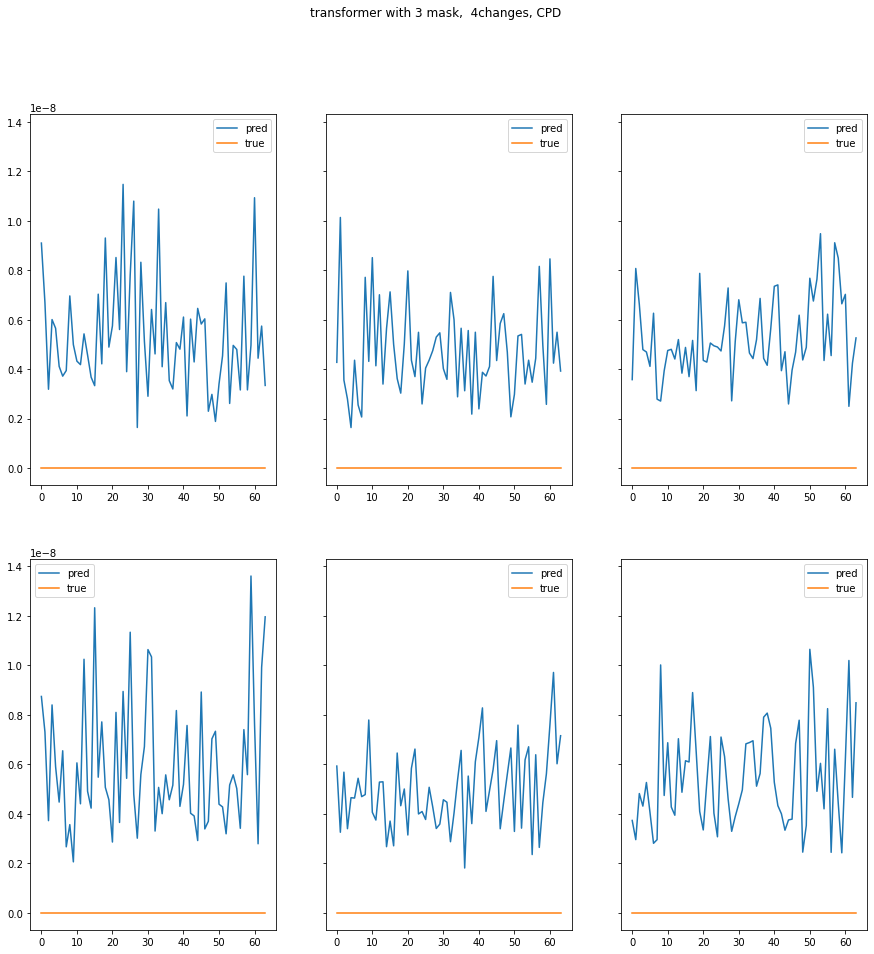

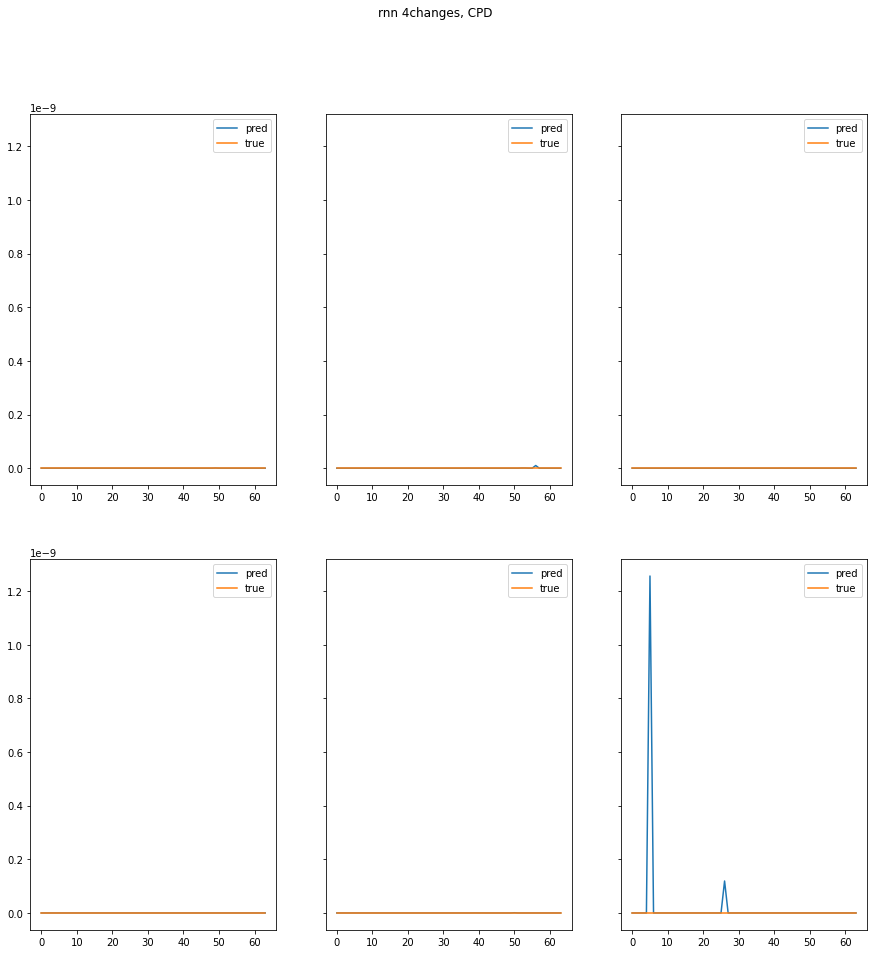

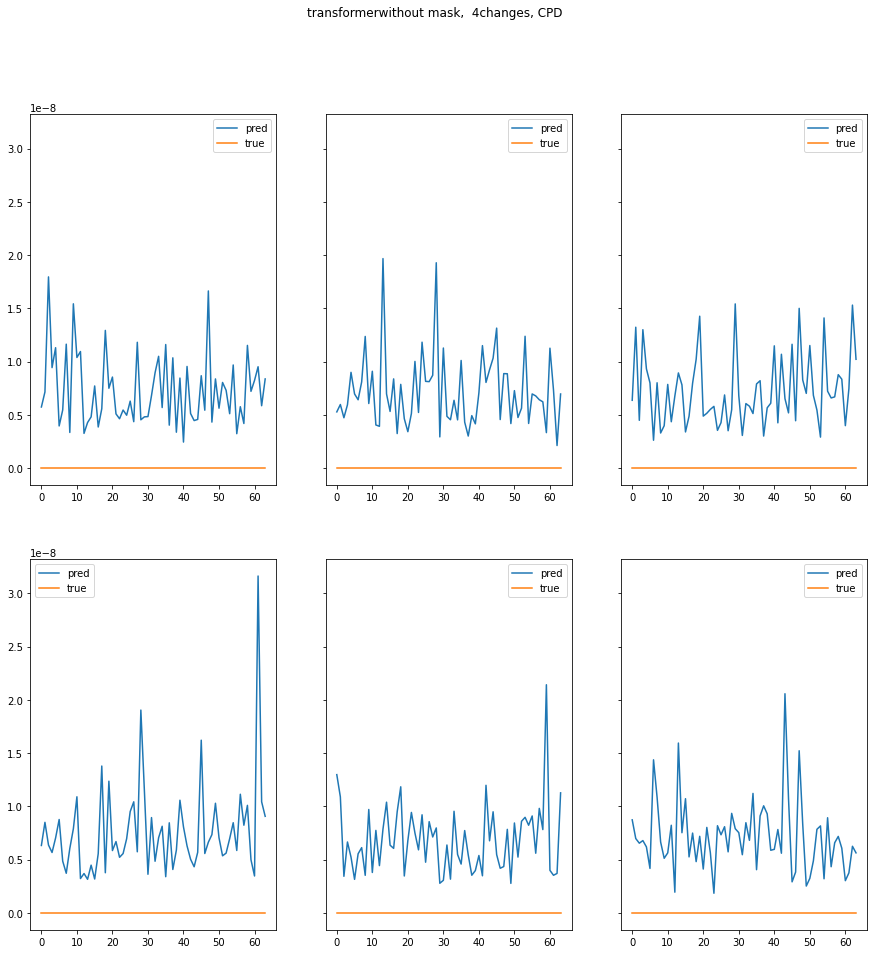

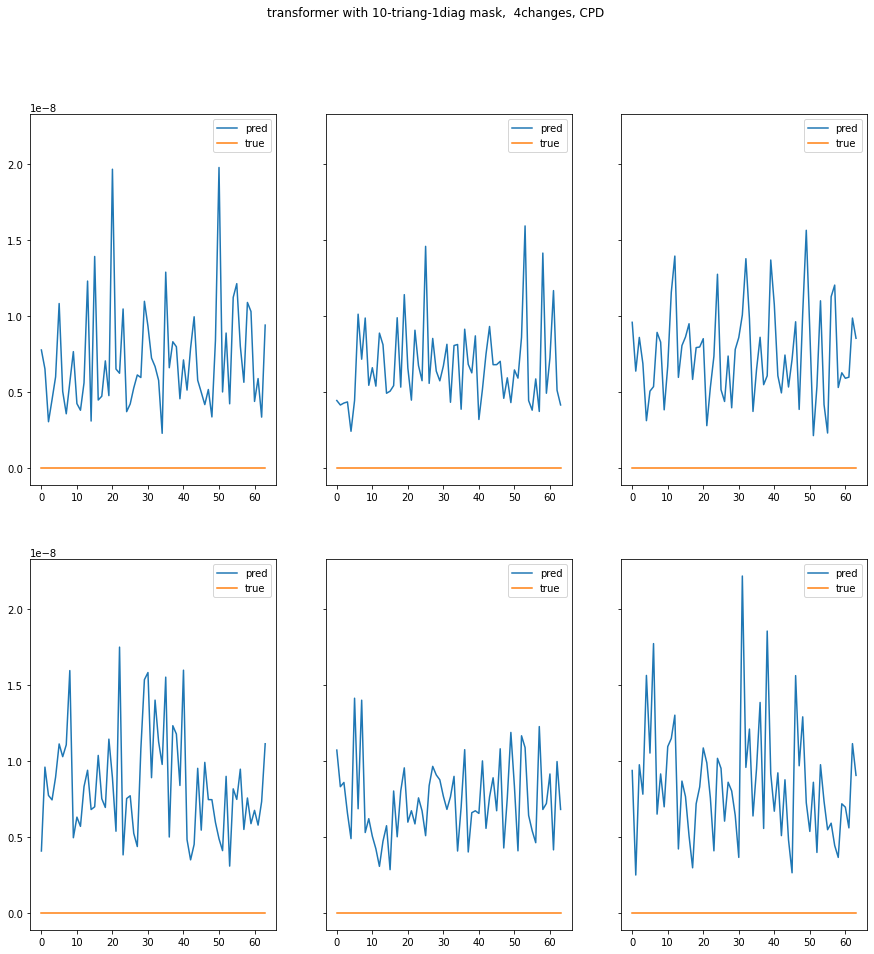

In [7]:
# Запустить эксперименты с трансформером с 3 масками, RNN, трансформером без маски, 
# трансформером с 1-диагональной маской и 10-нижне-треугольной маской
for exp in [ '3masks', 'rnn', 'transformer', 'triang-1diag']: #
    for sq in [64]:
        dataset_name =  '4changes'#'mnist' + str(sq)
        my_train(N=[0], D=[10], SEQ_LEN=sq, max_epochs=60
                     dataset_name=dataset_name,
                     exp=exp, exp_type='cpd')

In [73]:
IM_SIZE = 28
input_size = IM_SIZE * IM_SIZE
hidden_rnn = 10 #100
rnn_n_layers = 2
linear_dims = [100, 50]
rnn_dropout = 0.5
dim_feedforward = 50
models_metrics = []
nhead = 4
SEQ_LEN = 64
dataset_name="mnist" + str(SEQ_LEN)
dataset_name = '2changes'
exp = 'triang-1diag'
n=0
d=8
exp_type='cpd'
without_mask = False
replace=False
# replace == True: we wwant to get all hyperparametrs in mask uniformly
if exp[-4:] == 'diag' and replace == True:
    D = np.linspace(1, int(SEQ_LEN/2), int(np.log2(512)), dtype=int)
# N - amount of experiment's repeating

if exp in ['triang', '3masks', 'transformer', 'rnn'] :
    exp_name = exp
else:
    exp_name = str(d)+'-'+str(exp)
model_metric = []

if exp == 'transformer':
    base_model = models.MnistTransformer(
                                     input_size=input_size, name_mask='without',
                                     linear_dims=linear_dims, nhead=nhead,
                                     dim_feedforward=dim_feedforward, dropout=0.5, flag_mask=False)
    without_mask = True
if exp == 'rnn':
    base_model = models.MnistRNN(input_size, hidden_rnn, rnn_n_layers, linear_dims, rnn_dropout=0.0, 
                                 dropout=0.5,  rnn_type='LSTM')
    without_mask = True
if exp == '3masks':
    base_model = models.MnistTransformer_3masks(
                                          input_size=input_size, linear_dims=linear_dims, seq_len=SEQ_LEN,
                                          nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.5)


if exp not in ['3masks', 'rnn', 'transformer']:
    mask = get_mask(d=d, exp=exp, SEQ_LEN=SEQ_LEN)#.to('cuda')                                           

    base_model = models.MnistTransformer(
                                    input_size=input_size, linear_dims=linear_dims,
                                    src_mask=~mask, name_mask=exp_name,
                                    nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.5)


train_model = models.CPD_model(
                                model=base_model, T=SEQ_LEN, # // 4,
                                loss_type='CPD',
                                experiment_type=dataset_name,  #'mnist'+str(SEQ_LEN),
                                lr=0.001, 
                                batch_size=64)

current_time = datetime.datetime.now().strftime("%m%d%Y_%H-%M-%S")
if dataset_name[-7:] == 'changes':
    path_ = 'n_changes_experiment/'+dataset_name
elif dataset_name[:4] == 'mnist':
    path_ = 'seqlen_experiment/'+dataset_name

logger = pl.loggers.TensorBoardLogger(save_dir=path_+'/logs/'+exp_name+'/'+str(SEQ_LEN),
                                      name=experiment_name, log_graph=True)
early_stop_callback = EarlyStopping(monitor="val_loss", 
                                    min_delta=0.00,
                                    patience=10, 
                                    verbose=True, 
                                    mode="min")

checkpoint_callback = ModelCheckpoint( dirpath=path_+'/saves/'+exp_name,
    filename=str(SEQ_LEN)+'_'+exp_name+'_v'+str(n)+'_'+exp_type+'_{epoch}-{val_loss:.2f}-{val_acc:.2f}', 
    every_n_epochs=1)

In [74]:
trainer = pl.Trainer(
                    max_epochs=60, 
                    gpus=1, 
                    benchmark=True, 
                    check_val_every_n_epoch=1,
                    gradient_clip_val=0.5,
                    logger = logger,
                    callbacks = [
                        #callback,
                        early_stop_callback,
                        checkpoint_callback])
trainer.fit(train_model)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type             | Params
-------------------------------------------
0 | model | MnistTransformer | 2.5 M 
1 | loss  | CPDLoss          | 0     
-------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.180    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.391


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_acc did not improve in the last 15 records. Best score: 0.391. Signaling Trainer to stop.


Device in prediction's plots:  cpu
Not module transformer_3masks
Src mask is on  cpu
transformer with 8-triang-1diag mask,  2changes, CPD


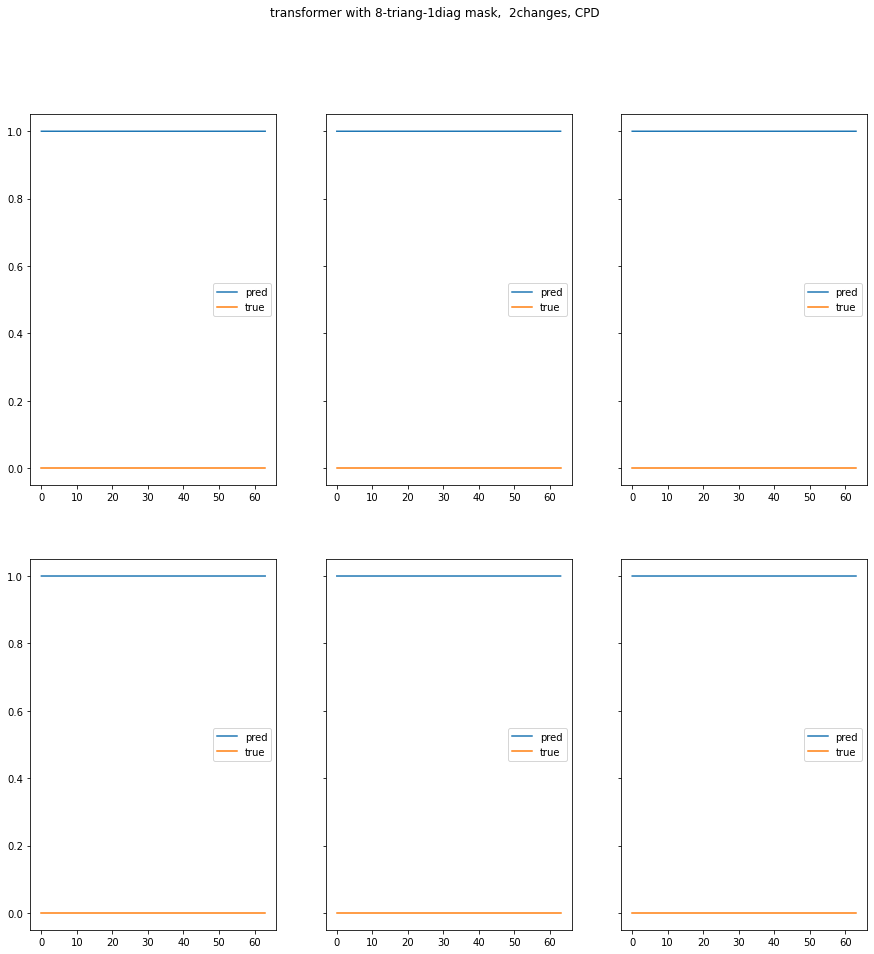

In [75]:
plot_pred(train_model, SEQ_LEN, dataset_name, n_rows=2, n_cols=3, without_mask=True,  savefigure=True)

Device in prediction's plots:  cpu
Not module transformer_3masks
Src mask is on  cpu
transformer with 8-triang-1diag mask,  2changes, CPD
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 600, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.

['64_8-triang-1diag_v0_cpd_2changes',
 801.76,
 0.3461759440104167,
 0.13793103448275862,
 0.0,
 0.3461759440104167,
 0.13793103448275862,
 0.0,
 0.3461759440104167,
 0.13793103448275862,
 0.0]

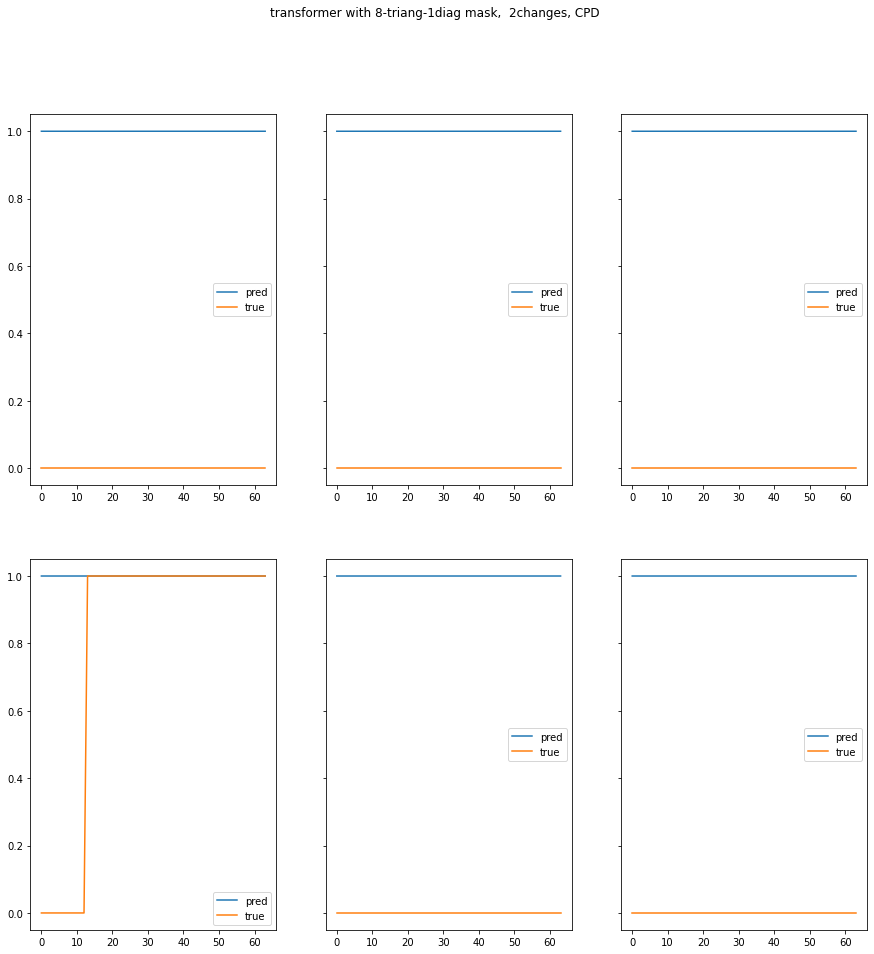

In [76]:
get_model_metrics(train_model=train_model, 
                  base_model=base_model, n=n,
                  exp_type=exp_type,
                  exp_name=exp_name, 
                  SEQ_LEN=SEQ_LEN,
                  threshold_number = 20,
                  dataset_name=dataset_name,
                  without_mask=without_mask,
                  savefigure=True, #False don't save images
                  savetext=True
                 )

In [66]:
from CPD import utils

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | MnistTransformer_3masks | 2.5 M 
1 | loss  | CPDLoss                 | 0     
--------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.180    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -8.283


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 8 records. Best score: -8.283. Signaling Trainer to stop.


64 3masks_v0_cpd
All masks are on  cpu
Not module transformer with mask
cpu
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, TN: 600, FN: 600, DELAY:23.3975, FP_DELAY:64.0
TP: 0, FP: 0, T

/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type     | Params
-----------------------------------
0 | model | MnistRNN | 38.9 K
1 | loss  | CPDLoss  | 0     
-----------------------------------
38.9 K    Trainable params
0         Non-trainable params
38.9 K    Total p

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.767


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 7.241 >= min_delta = 2.0. New best score: -5.474


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 4.329 >= min_delta = 2.0. New best score: -9.803


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 3.800 >= min_delta = 2.0. New best score: -13.603


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 4.600 >= min_delta = 2.0. New best score: -18.203


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 8.070 >= min_delta = 2.0. New best score: -26.273


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 4.681 >= min_delta = 2.0. New best score: -30.954


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 3.639 >= min_delta = 2.0. New best score: -34.594


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 2.069 >= min_delta = 2.0. New best score: -36.663


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

64 rnn_v0_cpd
Not module transformer_3masks
Not module transformer with mask
cpu
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 438, FP: 161, TN: 598, FN: 3, DELAY:0.19, FP_DELAY:40.925
TP: 441, FP: 158, TN: 598, FN: 3, DELAY:0.19166666666666668, FP_DELAY:40.95583333333333
TP: 443, FP: 152, TN: 602, FN: 3, DELAY:0.19416666666666665, FP_DELAY:41.10333333333333
TP: 444, FP: 149, TN: 603, FN: 4, DELAY:0.22583333333333333, FP_DELAY:41.1925
TP: 453, FP: 139, TN: 603, FN: 5, DELAY:0.27666666666666667, FP_DELAY:41.26583333333333
TP: 453, FP: 138, TN: 604, FN: 5, DELAY:0.2783333333333333, FP_DELAY:41.280833333333334
TP: 454, FP: 136, TN: 605, FN: 5, DELAY:0.2783333333333333, FP_DELAY:41.303333333333335
TP: 457, FP: 133, TN: 605, FN: 5, DELAY:0.2783333333333333, FP_DELAY:41.32083333333333
TP: 457, FP: 130, TN: 607, FN: 6, DELAY:0.28833333333333333, FP_DELAY:41.37833333333333
TP: 458, FP: 128, TN: 608, FN: 6, DELAY:0.2891666666666667, FP_DELAY:41.435
TP: 460, FP: 125, TN: 609, FN: 6,

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type             | Params
-------------------------------------------
0 | model | MnistTransformer | 2.5 M 
1 | loss  | CPDLoss          | 0     
-------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.180    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.983


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 8 records. Best score: 0.983. Signaling Trainer to stop.


64 transformer_v0_cpd
Not module transformer_3masks
Not module transformer with mask
cpu
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type             | Params
-------------------------------------------
0 | model | MnistTransformer | 2.5 M 
1 | loss  | CPDLoss          | 0     
-------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.180    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 8 records. Best score: 1.000. Signaling Trainer to stop.


64 10-triang-1diag_v0_cpd
Not module transformer_3masks
All masks are on  cpu
cpu
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0.0, FP_DELAY:0.0
TP: 0, FP: 1200, TN: 0, FN: 0, DELAY:0

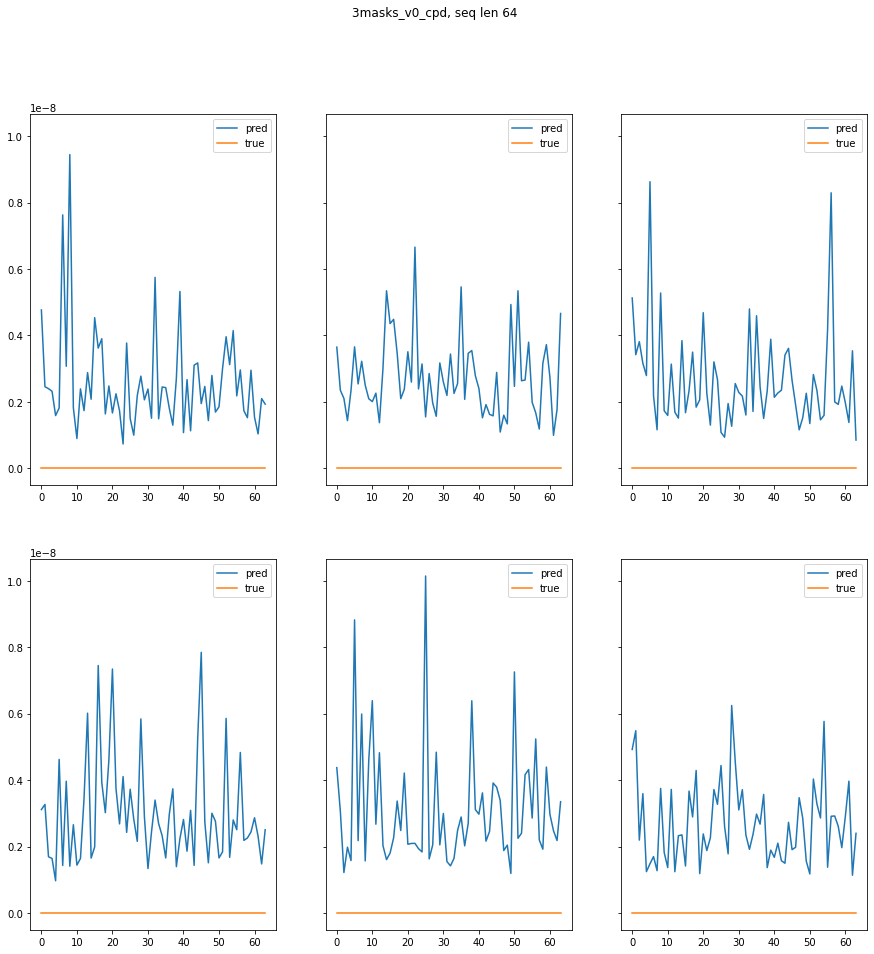

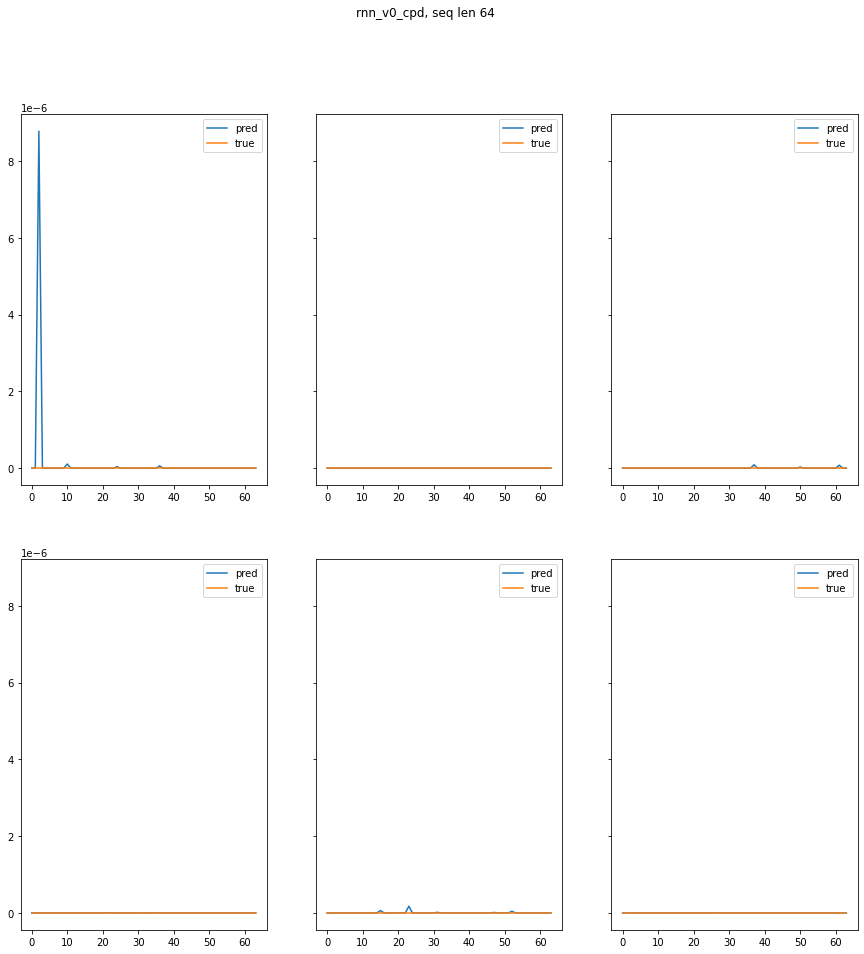

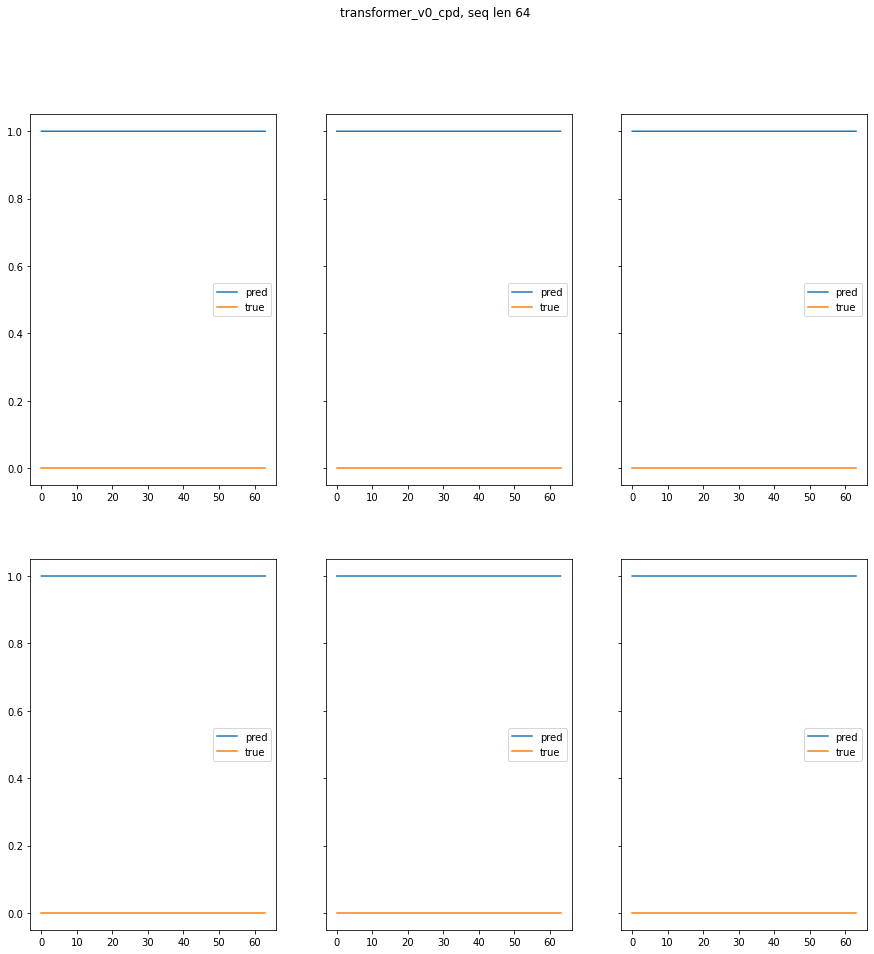

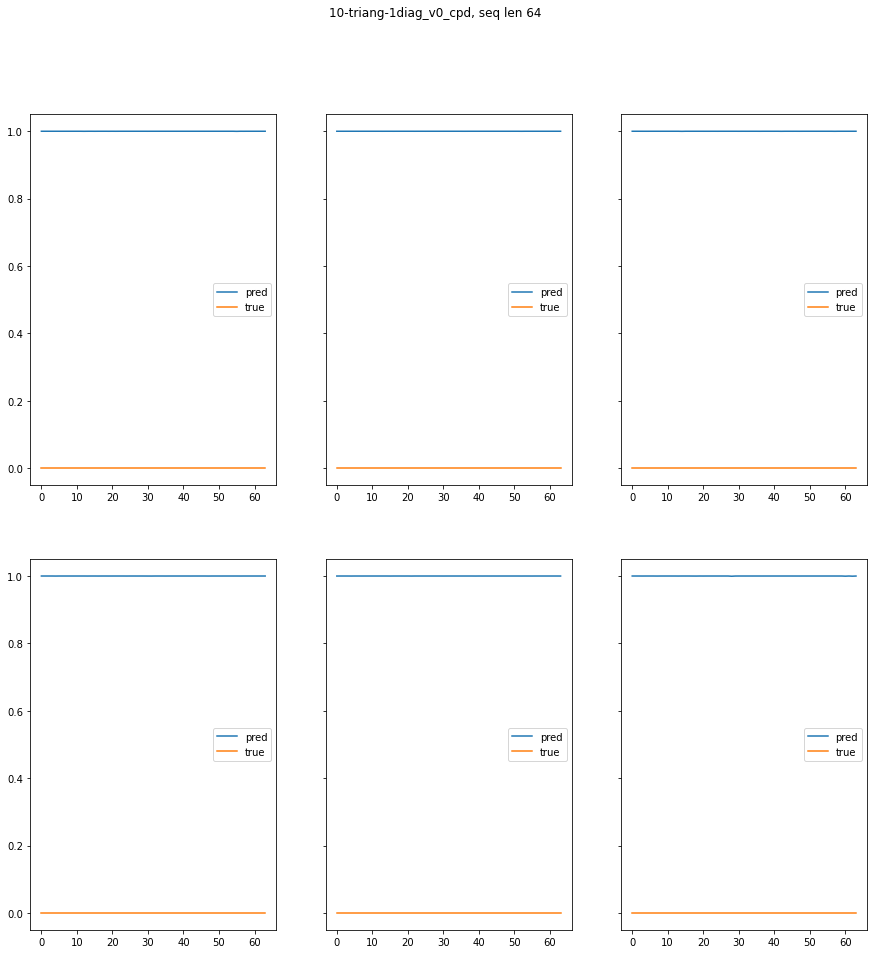

In [13]:
# Запустить эксперименты с трансформером с 3 масками, RNN, трансформером без маски, 
# трансформером с 1-диагональной маской и 10-нижне-треугольной маской
for exp in ['3masks', 'rnn', 'transformer', 'triang-1diag']:
        my_train(N=[0], D=[10], seq_len=[64], #[64*(2**i) for i in range(3,4)], 
                 exp=exp, exp_folder='new', exp_type='cpd')